In [9]:
import numpy as np
import matplotlib.pyplot as plt

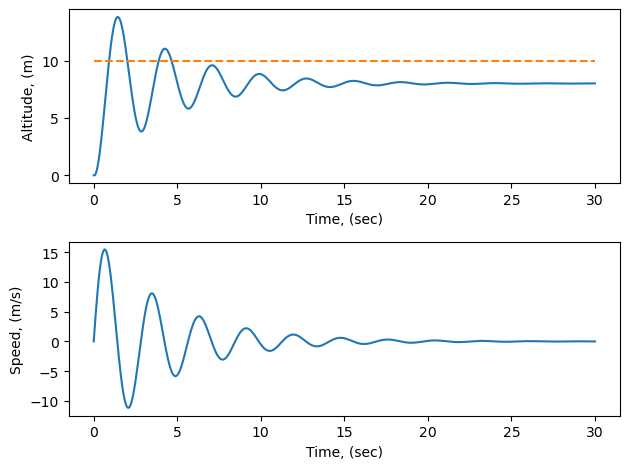

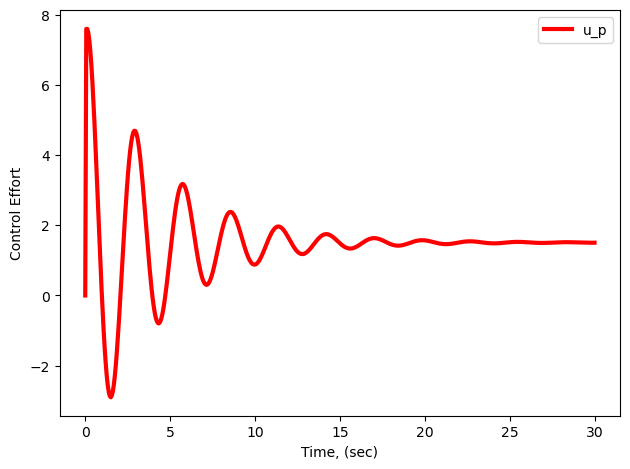

The rise time is 0.962 seconds
The percent overshoot is 38.2%
The steady state offset at 30 seconds is 1.981 meters


In [15]:
kp = 0.76

ki = 0.10

# Simulation parameters
N = 500 # number of simultion points
t0 = 0  # starting time, (sec)
tf = 30 # end time, (sec)
time = np.linspace(t0, tf, N)
dt = time[1] - time[0] # delta t, (sec)

# Inital conditions (i.e., initial state vector)
y = [0, 0]  #y[0] = initial altitude, (m)   #y[1] = initial speed, (m/s)

# Initialize array to store values
soln = np.zeros((len(time),len(y)))

# Create instance of P_Controller class
p = P_Controller()

# Set the Kp value of the controller
p.setKP(kp)

# Set the Kd value of the controller
pid.setKD(kd)

# Set altitude target
r = 10 # meters
p.setTarget(r)

# Simulate quadrotor motion
j = 0 # dummy counter
for t in time:
    # Evaluate state at next time point
    y = ydot(y,t,p)
    # Store results
    soln[j,:] = y
    j += 1

##################################################################################
# Plot results
SP = np.ones_like(time)*r # altitude set point
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(time, soln[:,0],time,SP,'--')
ax1.set_xlabel('Time, (sec)')
ax1.set_ylabel('Altitude, (m)')

ax2 = fig.add_subplot(212)
ax2.plot(time, soln[:,1])
ax2.set_xlabel('Time, (sec)')
ax2.set_ylabel('Speed, (m/s)')
plt.tight_layout()
plt.show()

fig2 = plt.figure()
ax3 = fig2.add_subplot(111)
ax3.plot(time, p.u_p, label='u_p', linewidth=3, color = 'red')
ax3.set_xlabel('Time, (sec)')
ax3.set_ylabel('Control Effort')
h, l = ax3.get_legend_handles_labels()
ax3.legend(h, l)
plt.tight_layout()
plt.show()
##################
y0 = soln[:,0] #altitude
rise_time_index =  np.argmax(y0>r)
RT = time[rise_time_index]
print("The rise time is {0:.3f} seconds".format(RT))

OS = (np.max(y0) - r)/r*100
if OS < 0:
    OS = 0
print("The percent overshoot is {0:.1f}%".format(OS))

print ("The steady state offset at 30 seconds is {0:.3f} meters".format(abs(soln[-1,0]-r)))

In [13]:
class P_Controller:
    def __init__(self, kp = 0.0, ki=0.0, start_time = 0):
        
        # The P controller can be initalized with a specific kp value
        self.kp_ = float(kp)
        self.ki_ = float(ki)
        self.kd_ = float(kd)
        
        # Store last timestamp
        self.set_point_ = 0.0
        self.start_time_ = start_time
        self.last_timestamp_ = 0.0
        self.error_sum_ = 0.0
        self.last_error_ = 0.0

        # Control effort history
        self.u_p = [0]
        self.u_i = [0]
        self.u_d = [0]

      
    # Set the altitude set point
    def setTarget(self, target):
        self.set_point_ = float(target)

    def setKP(self, kp):
        self.kp_ = float(kp)
        
    def setKI(self, ki):
        self.ki_ = float(ki)
        
    def setKD(self, kd):
        self.kd_ = float(kd)


    def update(self, measured_value, timestamp):
        delta_time = timestamp - self.last_timestamp_
        
        if delta_time == 0:
            return 0
        
        error = self.set_point_ - measured_value
        
        self.last_timestamp_ = timestamp
        
        self.error_sum_ += error * delta_time
        
        # Calculate the delta_error
        delta_error = error - self.last_error_
        
        # Update the past error with the current error
        self.last_error_ = error
        
        p = self.kp_ * error
        
        # Calculate the integral error here. Be sure to access the 
        # the internal Ki class variable
        ########################################
        i = self.ki_ * self.error_sum_
        ########################################
        
        # Derivative error 
        d = self.kd_ * (delta_error / delta_time)
        
        # Set the control effort
        # u is the sum of all your errors. In this case it is just 
        # the proportional and integral error.
        ########################################
        u = p + i + d 
        ########################################
        
        # Here we are storing the control effort history for post control
        # observations. 
        self.u_p.append(p)
        self.u_i.append(i)
        self.u_d.append(d)

        return u
    
    

IndentationError: expected an indented block (1138296903.py, line 33)

In [14]:
def ydot(y, t, p):
    ''' 
    y(k+1) = [y[0], y[1]] = y(k) + ydot*dt
    '''

    # Model state
    y0 = y[0] # altitude, (m)
    y1 = y[1] # speed, (m/s)


    # Model parameters
    g = -9.81 # gravity, m/s/s
    m =  1.54 # quadrotor mass, kg
    c =  10.0 # electro-mechanical transmission constant

    # time step, (sec)
    dt = t - p.last_timestamp_
    # Control effort
    u = p.update(y0,t)

    ### State derivatives
    # if altitude = 0
    if (y0 <= 0.):
        # if control input, u <= gravity, vehicle stays at rest on the ground
        # this prevents quadrotor from "falling" through the ground when thrust is
        # too small.
        if u <= np.absolute(g*m/c):
            y0dot = 0.
            y1dot = 0.
        else:  # else if u > gravity and quadrotor accelerates upwards
            y0dot = y1
            y1dot = g + c/m*u - 0.75*y1
    else: # otherwise quadrotor is already in the air
        y0dot = y1
        y1dot = g + c/m*u - 0.75*y1

    y0 += y0dot*dt
    y1 += y1dot*dt
    return [y0, y1]